In [111]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
driver = PySCFDriver(
    atom="He 0 0 0; H+ 0 0 0.772",
    basis="sto-3g",
    charge=1,
    spin=0,
)

problem = driver.run()
#print(problem)

In [112]:
fermionic_op = problem.hamiltonian.second_q_op()
#print(fermionic_op)
print('spatial orbitals: ', problem.num_spatial_orbitals)
print('spin orbitals: ', problem.num_spin_orbitals)
print('num particles: ', problem.num_particles)


spatial orbitals:  2
spin orbitals:  4
num particles:  (1, 1)


In [113]:
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper

mapper = JordanWignerMapper()
qubit_jw_op = mapper.map(fermionic_op)
print(qubit_jw_op)


SparsePauliOp(['IIII', 'IIIZ', 'IIYY', 'IIXX', 'IIZI', 'IZII', 'YYII', 'XXII', 'ZIII', 'IIZZ', 'IZIZ', 'YYIZ', 'XXIZ', 'ZIIZ', 'IZYY', 'IZXX', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'ZIYY', 'ZIXX', 'IZZI', 'YYZI', 'XXZI', 'ZIZI', 'ZZII'],
              coeffs=[-2.91290137+0.j,  0.75891361+0.j,  0.05246557+0.j,  0.05246557+0.j,
  0.19140054+0.j,  0.75891361+0.j,  0.05246557+0.j,  0.05246557+0.j,
  0.19140054+0.j,  0.12887694+0.j,  0.23578727+0.j,  0.04322997+0.j,
  0.04322997+0.j,  0.16528642+0.j,  0.04322997+0.j,  0.04322997+0.j,
  0.03640948+0.j,  0.03640948+0.j,  0.03640948+0.j,  0.03640948+0.j,
 -0.00923466+0.j, -0.00923466+0.j,  0.16528642+0.j, -0.00923466+0.j,
 -0.00923466+0.j,  0.18815906+0.j,  0.12887694+0.j])


In [114]:
from qiskit.quantum_info import Z2Symmetries, SparsePauliOp, Operator
def reduce_operator(op, reduced=False):
    if reduced:
        z2_symmetries = Z2Symmetries.find_z2_symmetries(op)
        newOp = Z2Symmetries(z2_symmetries.symmetries, z2_symmetries.sq_paulis, z2_symmetries.sq_list)
        tapered_ops = newOp.taper(op)
        print(tapered_ops)
        first_tapered_op = tapered_ops[1]
        return first_tapered_op
    else:
        return op
    
operator = reduce_operator(qubit_jw_op, reduced=True)
        
#print('sq_list: ',Z2Symmetries.find_z2_symmetries(qubit_jw_op).sq_list)
#print('sq_paulis: ',Z2Symmetries.find_z2_symmetries(qubit_jw_op).sq_paulis)
#print('Symmetries: ',Z2Symmetries.find_z2_symmetries(qubit_jw_op).symmetries)


[SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[-2.65514749+0.j,  0.95031416+0.j,  0.95031416+0.j,  0.75451917+0.j]), SparsePauliOp(['II', 'IZ', 'ZI', 'XI', 'ZZ', 'XZ'],
              coeffs=[-2.91290137+0.j,  0.95031416+0.j, -0.56751307+0.j, -0.10493114+0.j,
 -0.04762822+0.j, -0.06799062+0.j]), SparsePauliOp(['II', 'IZ', 'IX', 'ZI', 'ZZ', 'ZX'],
              coeffs=[-2.91290137+0.j, -0.56751307+0.j, -0.10493114+0.j,  0.95031416+0.j,
 -0.04762822+0.j, -0.06799062+0.j]), SparsePauliOp(['II', 'IZ', 'IX', 'ZI', 'XI', 'ZZ', 'XZ', 'ZX', 'XX'],
              coeffs=[-3.17065525+0.j, -0.56751307+0.j, -0.10493114+0.j, -0.56751307+0.j,
 -0.10493114+0.j,  0.09337348+0.j,  0.10492927+0.j,  0.10492927+0.j,
  0.14563793+0.j])]


In [115]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}



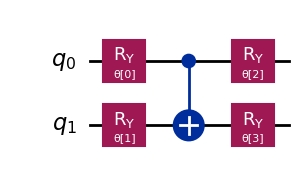

In [116]:
from qiskit_algorithms.optimizers import SLSQP,SPSA,COBYLA, L_BFGS_B
from qiskit_algorithms import VQE
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()
ansatz = RealAmplitudes(operator.num_qubits, reps=1)
optimizer = SLSQP()
ansatz.decompose().draw('mpl')

In [117]:
def cost_func_vqe(parameters, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])
    estimator_result = estimator_job.result()[0]

    cost = estimator_result.data.evs[0]
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = parameters
    cost_history_dict["cost_history"].append(cost)
    return cost

In [118]:
from scipy.optimize import minimize
import numpy as np
initial_params = np.random.uniform(low= -np.pi, high=np.pi, size=ansatz.num_parameters)

In [119]:
result = minimize(cost_func_vqe, initial_params, args=(ansatz, operator, estimator), method="COBYLA",options={'maxiter': 12000})
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.384411132069359
       x: [-7.588e-05  4.042e+00 -3.142e+00  2.312e+00]
    nfev: 67
   maxcv: 0.0


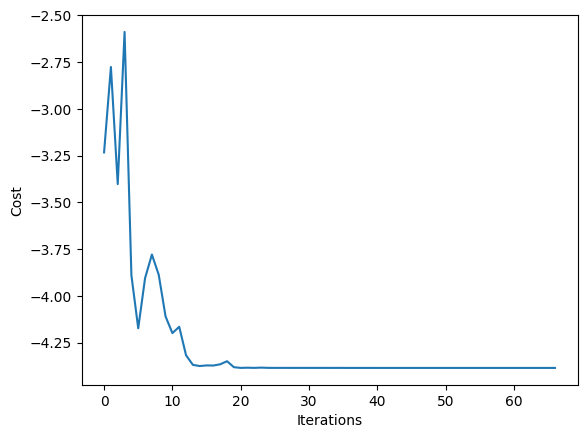

In [120]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()